# Chemical Exchange

Chemical exchange is an important phenomenon in magnetic resonance, where a chemical or physical change in a molecule gives rise to a modulation in the chemical shift for a given spin. Depending on the rate of exchange between two or more chemical shifts, we may observe the effects of exchange using a number of different experiments.

The following tutorial will introduce this concept and investigate effects of various parameters on several different experiments. We'll use SLEEPY (http://sleepy-nmr.org) to support our investigations, so take some time to experiment with the software as you go.

In [3]:
# Make sure SLEEPY is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !pip install sleepy-nmr
elif 'USER' in os.environ and os.environ['USER']=='jovyan': #Binder
    !pip install sleepy-nmr
else:
    os.chdir('../../..')

## Setup

In [18]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

The most basic experiment for observing chemical exchange is a simple 1D experiment, where we exchange between chemical shifts. In this experiment, evolution of a coherence under the chemical shift depends on the state of the system, for example:

$$
\begin{eqnarray}
\frac{d}{dt}\langle\hat{S}^+\rangle_1^+&=&-i\Omega_1\langle\hat{S}^+\rangle_2 \:\mathrm{ : state 1} \\
\frac{d}{dt}\langle\hat{S}^+\rangle_2^+&=&-i\Omega_2\langle\hat{S}^+\rangle_2 \:\mathrm{ : state 2}
\end{eqnarray}
$$

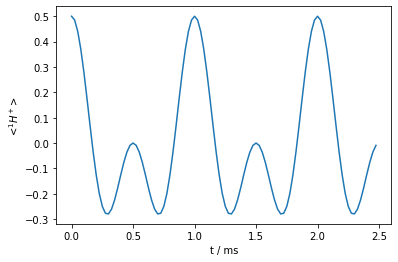

In [19]:
ex0=sl.ExpSys(v0H=500,Nucs='1H')    #Experimental system at 500 MHz with one 1H
ex0.set_inter('CS',i=0,Hz=2000)     #Add a chemical shift to the system
ex1=ex0.copy()                      #Copy system for second system in exchange 
ex1.set_inter('CS',i=0,Hz=-1000)    #Add a chemical shift to the second system
L=sl.Liouvillian(ex0,ex1)               #Generate a Liouvillian for the system
seq=L.Sequence(Dt=1/(40000))       #Sequence with a 25 microsecond length

rho=sl.Rho(rho0='1Hx',detect='1Hp')
rho.DetProp(seq,n=100)
_=rho.plot()

As we see, the system simply oscillates at the given input frequencies. Below, we can check what that frequency actually is, by taking the Fourier transform of the above signal, where we see that indeed it oscillates at +2 kHz and -1 kHz.

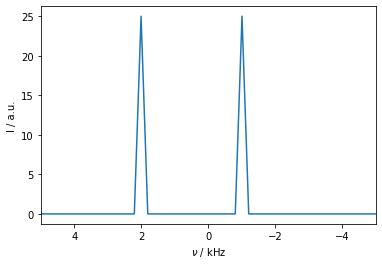

In [15]:
ax=rho.plot(FT=True)
_=ax.set_xlim([5,-5])

## Exercise 1:
Typing any of the above objects at the command line will produce a description of the object. Objects also have a plot function (`ex0`,`ex1` have a `plot_inter` function, although this is not so informative for isotropic interactions). Try this to get a feeling for what the critical settings are in this simulation. What is the role of each object in the simulation?

In [ ]:
# Use this cell to investigate the different objects

```{toggle}
* ExpSys (ex0,ex1) : defines spins in the magnetic field, spins in the system, and interactions

* Liouvillian (L) : Contains each of the ExpSys objects and the Liouvillian matrix, as well as an exchange matrix (currently set to zeros).

* Sequence (seq) : Contains definitions of the field strengths, and defines length of propagation steps.

* Rho (rho) : Contains the initial state of the system and the detection matrix, as well as the signal.
```

Now, assume that the system is in one of two states, with chemical shift frequencies $\Omega_1$ and $\Omega_2$. Depending on which state we're in, we have either

$$
\begin{eqnarray}
\frac{d}{dt}\langle\hat{S}^+\rangle&=&-i\Omega_1\langle\hat{S}^+\rangle \\
\frac{d}{dt}\langle\hat{S}^+\rangle&=&-i\Omega_2\langle\hat{S}^+\rangle
\end{eqnarray}
$$

Then, if we hop randomly from state 1 to 2 and vice versa, with rate constants $k_{12}$ and $k_{21}$, we have the following exchange matrix.

$$
\mathbf{k}=
\begin{pmatrix}
-i\Omega_1 - k_{12} & k_{21} \\ k_{12} & -i\Omega_2 - k_{21}
\end{pmatrix}
$$

This can be combined into a single matrix including the oscillation, which yields the following differential equation:

$$
\frac{d}{dt}
\begin{pmatrix}
\langle\hat{S}^+_1\rangle \\ \langle\hat{S}^+_1\rangle
\end{pmatrix}
=
\begin{pmatrix}
-i\Omega_1 - k_{12} & k_{21} \\ k_{12} & -i\Omega_2 - k_{21}
\end{pmatrix}
\cdot
\begin{pmatrix}
\langle\hat{S}^+_1\rangle \\ \langle\hat{S}^+_1\rangle
\end{pmatrix}
$$

This matrix indicates that if we are in state 1, the phase of $\hat{S}_1^+$ will oscillate with frequency of $\Omega_1$, but it will also diffuse with rate $k_{12}$ to state 2, where it will oscillate with frequency $\Omega_2$ and also potentially diffuse back to state one (with rate $k_{21}$).

## Exercise 2:
To understand exchange analytically, we often make some simplifying assumptions about the terms. First, we set $\Omega_1=\Delta\Omega/2$ and $\Omega_2=-\Delta\Omega/2$. We also assume symmetric exchange, such that $k_{12}=k_{21}=k$. This yields the following exchange matrix:

$$
\mathbf{k}=
\begin{pmatrix}
-i\Delta\Omega/2 - k & k \\ k & i\Delta\Omega/2 - k
\end{pmatrix}
$$

Find the eigenvalues of this matrix, where each eigenvalue represents the evolution of a signal in the NMR spectrum. We won't solve for the eigenvectors here, but these also play a role in the contributions of each signal.

Under what conditions do we observe two separated chemical shifts? What is $T_2$ in this case? What is $T_2$ if there is only one chemical shift?

Hint: $T_2$ is the negative inverse of the real part of the eigenvalues, whereas the imaginary part yields oscillation frequencies

The answer is given in multiple steps, so if you're not sure how to start, go ahead and open the first answer.

### Part 1
```{toggle}
Eigenvalues are found by calculating the determinant of the matrix minus $\lambda\cdot\mathbb{1}$, setting it to zero, and solving for the values of $\lambda$ ($\mathbb{1}$ is an identity matrix)

$$
0=\det
\begin{pmatrix}
-i\Delta\Omega/2-k-\lambda & k \\ k & i\Delta\Omega/2-k-\lambda
\end{pmatrix}
$$
```

### Part 2
```{toggle}
The determinant for a 2x2 matrix is calculated by taking the (0,0) element times the (1,1) element minus the (0,1) element times the (1,0) element.

$$
\begin{eqnarray}
0&=&(-i\Delta\Omega/2-k-\lambda)\cdot(i\Delta\Omega/2-k-\lambda)-k^2 \\
0&=&\lambda^2+2k\lambda+\frac{(\Delta\Omega)^2}{4}
\end{eqnarray}
$$
```

### Part 3
```{toggle}
We can solve for the eigenvalues using the quadratic formula.

$$
\begin{eqnarray}
0&=&ax^2+bx+c \\
x&=&\frac{-b\pm\sqrt{b^2-4ac}}{2a}
\end{eqnarray}
$$

Then,
$$
\lambda=\frac{-2k\pm\sqrt{4k^2-(\Delta\Omega)^2}}{2}
$$
```

### Part 4
```{toggle}
The real part of the eigenvalues is the negative inverse of $T_2$, whereas the imaginary part is the frequency. When $2k>\Delta\Omega$, then the eigenvalues are strictly real. This means that there is only a single frequency (at 0) in the spectrum, but a complex lineshape with two decay rates. On the other hand, if $2k<\Delta\Omega$, then two distinct frequencies emerge. The real part is then only $-k$, so $T_2=1/k$.

$$
\begin{matrix}
2k>>\Delta\Omega & T_2=\infty,1/(2k) & \Omega=0 \\
2k>\Delta\Omega & T_2=1/(k\mp\sqrt{k^2-(\Delta\Omega/2)^2}) & \Omega=0 \\
2k=\Delta\Omega & T_2=1/k & \Omega=0 \\
2k<\Delta\Omega & T_2=1/k & \Omega=\pm\sqrt{(\Delta\Omega/2)^2-k^2} \\
2k<<\Delta\Omega & T_2=1/k & \Omega=\pm\Delta\Omega/2
\end{matrix}
$$
Note that when $k>\Delta\Omega$, there are two peaks with the same apparent chemical shift. As $k$ gets large, the contribution of $T_2=1/(2k)$ becomes smaller, such that the peak becomes increasingly narrow, rather than wide.
```

## Exercise 3
Below, we set up a simulation with two different chemical shifts in exchange ($\pm$2000 Hz, so $\Delta\Omega=2*\pi*4000$ rad/s). Adjust $k$ to the different conditions in the solution above to observe the effect.

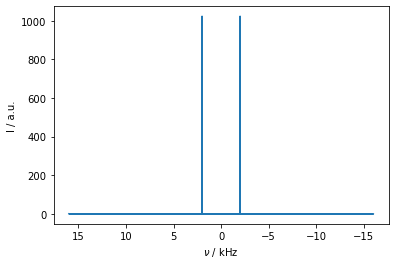

In [44]:
ex0=sl.ExpSys(500,Nucs='1H')
ex0.set_inter('CS',i=0,Hz=2000)
ex1=ex0.copy()
ex1.set_inter('CS',i=0,Hz=-2000)

L=sl.Liouvillian(ex0,ex1)
k=0
L.kex=[[-k,k],[k,-k]]

seq=L.Sequence(Dt=1/32000)

rho=sl.Rho(rho0='S0x',detect='S0p')
rho.DetProp(seq,n=4096)
_=rho.plot(FT=True)

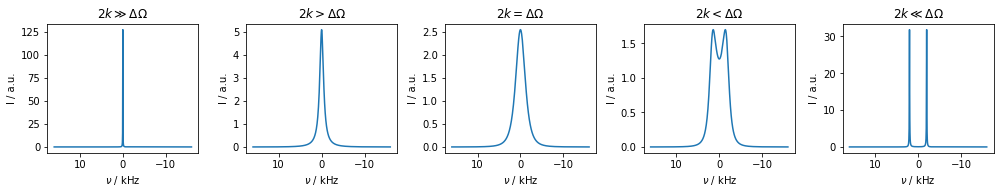

In [45]:
fig,ax=plt.subplots(1,5,figsize=[14,2.8])
sqrt0=2*np.pi*4000/2   #This is where the square root is zero
k0=[50*sqrt0,2*sqrt0,sqrt0,sqrt0/2,sqrt0/50]
titles=[rf'$2k{sign}\Delta\Omega$' for sign in ['\gg','>','=','<','\ll']]

for a,k,title in zip(ax,k0,titles):
    L.kex=[[-k,k],[k,-k]]
    rho.clear()
    rho.DetProp(seq,n=4096)
    rho.plot(FT=True,ax=a)
    a.set_title(title)
_=fig.tight_layout()